In [4]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from datetime import datetime
import copy

In [5]:
# Hyper parameter settings
EPOCH = 10 # Number of times to traverse the data set
BATCH_SIZE = 64 # Batch size (batch_size)
LR = 0.01 # learning rate
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [6]:
# Define the data preprocessing method
transform = transforms.ToTensor()

In [7]:
#Define training and test data set
trainset = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transform)
 #loading  data with dataloader
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False,)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



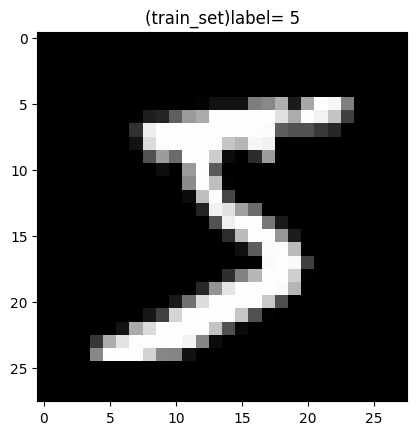

In [10]:
plt.imshow(trainset.train_data[0].numpy(),cmap='gray')
plt.title('(train_set)label= %i' % trainset.train_labels[0])
plt.show()

# check use cuda or cpu

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Alex Network Structure

In [12]:
class AlexNet(nn.Module):
    def __init__(self,width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 32*28*28
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*14*14
            nn.ReLU(inplace=True),
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64*14*14
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*7*7
            nn.ReLU(inplace=True),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128*7*7
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 256*7*7
            )
 
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 256*7*7
            nn.MaxPool2d(kernel_size=3, stride=2), # 256*3*3
            nn.ReLU(inplace=True),
            )
        self.fc1 = nn.Linear(256*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256*3*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [13]:
net = AlexNet().to(device)

In [14]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)
        x = net(images).to(device)
        value, pred = torch.max(x,1)
        pred = pred.data.to(device)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [15]:
# Train and save model parameters
def train():
    # Define loss function loss function and optimization method (using SGD)
    # Cross entropy loss function, usually used formulti-classification problems
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    max_accuracy=0
    accuracies=[]
    for epoch in range(EPOCH):
                 # Data read
        for i, (images,labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
                         # Gradient clear
            optimizer.zero_grad()
 
            # forward + backward
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(criterion, testloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(criterion)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  97.47000122070312
Epoch: 1 Accuracy : 97.47000122070312 %
Saving Best Model with Accuracy:  98.47000122070312
Epoch: 2 Accuracy : 98.47000122070312 %
Saving Best Model with Accuracy:  98.94999694824219
Epoch: 3 Accuracy : 98.94999694824219 %
Epoch: 4 Accuracy : 98.80999755859375 %
Epoch: 5 Accuracy : 98.08999633789062 %
Epoch: 6 Accuracy : 98.8499984741211 %
Saving Best Model with Accuracy:  98.98999786376953
Epoch: 7 Accuracy : 98.98999786376953 %
Saving Best Model with Accuracy:  99.13999938964844
Epoch: 8 Accuracy : 99.13999938964844 %
Epoch: 9 Accuracy : 99.06999969482422 %
Saving Best Model with Accuracy:  99.38999938964844
Epoch: 10 Accuracy : 99.38999938964844 %


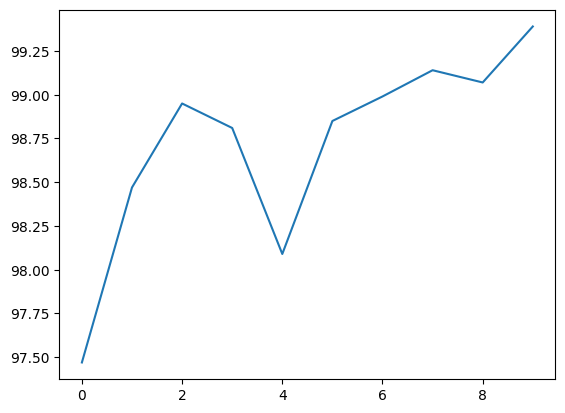

In [16]:
alexnet_model = train()

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

In [18]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        labels = labels.cpu()
        images = images.to(device)
        x = net(images).to(device)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [19]:
y_pred, y_true = predict_dl(alexnet_model,testloader)

In [20]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,1,0,0,1,1,0
1,0,1133,0,1,0,0,0,1,0,0
2,1,1,1026,1,0,0,0,3,0,0
3,0,0,0,1008,0,1,0,1,0,0
4,0,0,1,0,979,0,0,0,1,1
5,1,0,0,4,0,884,1,0,0,2
6,1,3,0,1,3,1,948,0,1,0
7,1,3,1,0,0,0,0,1019,1,3
8,0,0,2,1,0,0,0,0,969,2
9,0,0,0,0,9,0,0,4,0,996


In [21]:
model_path = 'model_{}_{}.pth'.format(timestamp, EPOCH)
torch.save(alexnet_model.state_dict(), model_path)

In [25]:

alexnet_model.eval()

CrossEntropyLoss()

In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
images = images.cpu().numpy()

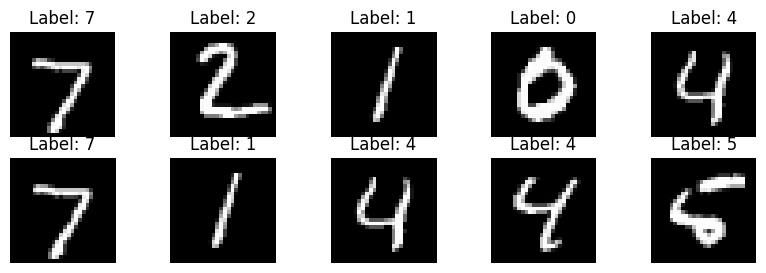

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(10, 3))
for i in range(2):
    for j in range(5):
        axes[i][j].imshow(np.squeeze(images[(i+1)*j]), cmap='gray')
        axes[i][j].set_title(f'Label: {predicted[(i+1)*j].item()}')
        axes[i][j].axis('off')

plt.show()